In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [55]:
# Root directory for dataset
dataroot = "/home/vignesh_pagadala/Desktop/GAN-Project/Main/Image-Pairs/Original/adobe2"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 2

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

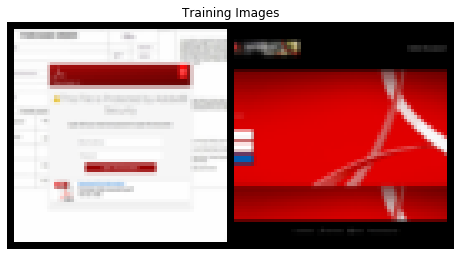

In [56]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [57]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [58]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [59]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [60]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [61]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [62]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [63]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            # ADD 1
            # vutils.save_image(fake, "img.png")
        iters += 1

Starting Training Loop...
[0/200][0/348]	Loss_D: 1.7968	Loss_G: 17.1793	D(x): 0.9354	D(G(z)): 0.7508 / 0.0000
[0/200][50/348]	Loss_D: 0.2509	Loss_G: 11.4691	D(x): 1.0000	D(G(z)): 0.2169 / 0.0000
[0/200][100/348]	Loss_D: 0.0760	Loss_G: 5.5961	D(x): 0.9473	D(G(z)): 0.0201 / 0.0039
[0/200][150/348]	Loss_D: 0.5448	Loss_G: 19.8419	D(x): 1.0000	D(G(z)): 0.3984 / 0.0000
[0/200][200/348]	Loss_D: 0.0063	Loss_G: 18.8704	D(x): 0.9937	D(G(z)): 0.0000 / 0.0000
[0/200][250/348]	Loss_D: 0.0429	Loss_G: 25.3625	D(x): 0.9588	D(G(z)): 0.0000 / 0.0000
[0/200][300/348]	Loss_D: 0.0002	Loss_G: 10.9770	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[1/200][0/348]	Loss_D: 0.1447	Loss_G: 16.5753	D(x): 0.8744	D(G(z)): 0.0000 / 0.0000
[1/200][50/348]	Loss_D: 0.0020	Loss_G: 7.4132	D(x): 0.9988	D(G(z)): 0.0008 / 0.0008
[1/200][100/348]	Loss_D: 0.4127	Loss_G: 14.0905	D(x): 0.9996	D(G(z)): 0.2809 / 0.0000
[1/200][150/348]	Loss_D: 0.0006	Loss_G: 14.0455	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[1/200][200/348]	Loss_D: 1.9484	Loss

[13/200][250/348]	Loss_D: 0.0015	Loss_G: 10.3264	D(x): 0.9986	D(G(z)): 0.0001 / 0.0001
[13/200][300/348]	Loss_D: 0.7212	Loss_G: 3.8355	D(x): 0.6259	D(G(z)): 0.0311 / 0.0225
[14/200][0/348]	Loss_D: 0.0264	Loss_G: 4.2922	D(x): 0.9986	D(G(z)): 0.0246 / 0.0154
[14/200][50/348]	Loss_D: 0.0061	Loss_G: 5.3889	D(x): 1.0000	D(G(z)): 0.0061 / 0.0047
[14/200][100/348]	Loss_D: 0.0768	Loss_G: 4.3596	D(x): 0.9999	D(G(z)): 0.0715 / 0.0305
[14/200][150/348]	Loss_D: 0.0007	Loss_G: 15.0637	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[14/200][200/348]	Loss_D: 0.0123	Loss_G: 5.9350	D(x): 0.9945	D(G(z)): 0.0067 / 0.0044
[14/200][250/348]	Loss_D: 0.0449	Loss_G: 4.1854	D(x): 0.9999	D(G(z)): 0.0432 / 0.0234
[14/200][300/348]	Loss_D: 0.0087	Loss_G: 4.9766	D(x): 1.0000	D(G(z)): 0.0086 / 0.0072
[15/200][0/348]	Loss_D: 0.0014	Loss_G: 8.4480	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002
[15/200][50/348]	Loss_D: 0.0450	Loss_G: 5.5777	D(x): 1.0000	D(G(z)): 0.0430 / 0.0184
[15/200][100/348]	Loss_D: 0.1245	Loss_G: 3.4356	D(x): 1.00

[27/200][150/348]	Loss_D: 0.0159	Loss_G: 5.1903	D(x): 1.0000	D(G(z)): 0.0157 / 0.0122
[27/200][200/348]	Loss_D: 0.0975	Loss_G: 3.7738	D(x): 0.9990	D(G(z)): 0.0879 / 0.1063
[27/200][250/348]	Loss_D: 0.0028	Loss_G: 5.9872	D(x): 1.0000	D(G(z)): 0.0028 / 0.0025
[27/200][300/348]	Loss_D: 1.0423	Loss_G: 2.0346	D(x): 0.9462	D(G(z)): 0.4721 / 0.1654
[28/200][0/348]	Loss_D: 0.0372	Loss_G: 13.9860	D(x): 0.9639	D(G(z)): 0.0000 / 0.0000
[28/200][50/348]	Loss_D: 0.0016	Loss_G: 8.1590	D(x): 0.9999	D(G(z)): 0.0016 / 0.0006
[28/200][100/348]	Loss_D: 0.0032	Loss_G: 5.8935	D(x): 1.0000	D(G(z)): 0.0031 / 0.0029
[28/200][150/348]	Loss_D: 0.0148	Loss_G: 4.4431	D(x): 1.0000	D(G(z)): 0.0146 / 0.0125
[28/200][200/348]	Loss_D: 0.0088	Loss_G: 5.4070	D(x): 0.9980	D(G(z)): 0.0068 / 0.0048
[28/200][250/348]	Loss_D: 0.0063	Loss_G: 7.8948	D(x): 0.9998	D(G(z)): 0.0061 / 0.0005
[28/200][300/348]	Loss_D: 0.0276	Loss_G: 6.0298	D(x): 0.9756	D(G(z)): 0.0026 / 0.0025
[29/200][0/348]	Loss_D: 0.0067	Loss_G: 5.2175	D(x): 0.99

[41/200][50/348]	Loss_D: 0.0220	Loss_G: 4.2378	D(x): 0.9927	D(G(z)): 0.0145 / 0.0145
[41/200][100/348]	Loss_D: 0.0009	Loss_G: 7.3803	D(x): 1.0000	D(G(z)): 0.0009 / 0.0007
[41/200][150/348]	Loss_D: 0.0362	Loss_G: 4.5870	D(x): 0.9996	D(G(z)): 0.0349 / 0.0129
[41/200][200/348]	Loss_D: 0.0096	Loss_G: 5.1280	D(x): 0.9997	D(G(z)): 0.0092 / 0.0059
[41/200][250/348]	Loss_D: 0.0097	Loss_G: 5.2527	D(x): 0.9983	D(G(z)): 0.0079 / 0.0054
[41/200][300/348]	Loss_D: 0.0142	Loss_G: 4.9724	D(x): 0.9996	D(G(z)): 0.0137 / 0.0070
[42/200][0/348]	Loss_D: 0.1744	Loss_G: 3.3758	D(x): 0.8665	D(G(z)): 0.0190 / 0.0360
[42/200][50/348]	Loss_D: 0.0065	Loss_G: 5.3489	D(x): 0.9999	D(G(z)): 0.0064 / 0.0048
[42/200][100/348]	Loss_D: 0.0046	Loss_G: 5.9437	D(x): 0.9990	D(G(z)): 0.0035 / 0.0029
[42/200][150/348]	Loss_D: 0.0063	Loss_G: 5.4023	D(x): 0.9999	D(G(z)): 0.0062 / 0.0046
[42/200][200/348]	Loss_D: 0.0056	Loss_G: 5.5296	D(x): 0.9995	D(G(z)): 0.0051 / 0.0040
[42/200][250/348]	Loss_D: 0.0040	Loss_G: 5.8494	D(x): 0.99

[54/200][300/348]	Loss_D: 0.2029	Loss_G: 3.3524	D(x): 0.8396	D(G(z)): 0.0104 / 0.0771
[55/200][0/348]	Loss_D: 0.0285	Loss_G: 6.2952	D(x): 0.9814	D(G(z)): 0.0096 / 0.0046
[55/200][50/348]	Loss_D: 0.0028	Loss_G: 6.3098	D(x): 0.9998	D(G(z)): 0.0026 / 0.0022
[55/200][100/348]	Loss_D: 0.0285	Loss_G: 6.2406	D(x): 0.9746	D(G(z)): 0.0024 / 0.0020
[55/200][150/348]	Loss_D: 0.0191	Loss_G: 11.3583	D(x): 0.9812	D(G(z)): 0.0000 / 0.0000
[55/200][200/348]	Loss_D: 0.0051	Loss_G: 6.2711	D(x): 0.9998	D(G(z)): 0.0049 / 0.0042
[55/200][250/348]	Loss_D: 0.0047	Loss_G: 6.2924	D(x): 0.9984	D(G(z)): 0.0031 / 0.0019
[55/200][300/348]	Loss_D: 0.0148	Loss_G: 6.5986	D(x): 1.0000	D(G(z)): 0.0146 / 0.0087
[56/200][0/348]	Loss_D: 0.0117	Loss_G: 4.8571	D(x): 0.9999	D(G(z)): 0.0116 / 0.0078
[56/200][50/348]	Loss_D: 0.0417	Loss_G: 3.9303	D(x): 0.9999	D(G(z)): 0.0407 / 0.0198
[56/200][100/348]	Loss_D: 0.0047	Loss_G: 12.1663	D(x): 0.9953	D(G(z)): 0.0000 / 0.0000
[56/200][150/348]	Loss_D: 0.0183	Loss_G: 4.8906	D(x): 0.99

[68/200][200/348]	Loss_D: 0.1066	Loss_G: 2.0549	D(x): 0.9569	D(G(z)): 0.0603 / 0.1301
[68/200][250/348]	Loss_D: 0.0040	Loss_G: 5.6796	D(x): 0.9996	D(G(z)): 0.0035 / 0.0034
[68/200][300/348]	Loss_D: 0.0007	Loss_G: 7.4187	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[69/200][0/348]	Loss_D: 0.0134	Loss_G: 6.1006	D(x): 0.9891	D(G(z)): 0.0024 / 0.0024
[69/200][50/348]	Loss_D: 0.0032	Loss_G: 6.1760	D(x): 1.0000	D(G(z)): 0.0031 / 0.0030
[69/200][100/348]	Loss_D: 0.0065	Loss_G: 5.1899	D(x): 0.9999	D(G(z)): 0.0064 / 0.0056
[69/200][150/348]	Loss_D: 0.0110	Loss_G: 5.1780	D(x): 1.0000	D(G(z)): 0.0109 / 0.0061
[69/200][200/348]	Loss_D: 0.0024	Loss_G: 6.4325	D(x): 1.0000	D(G(z)): 0.0024 / 0.0022
[69/200][250/348]	Loss_D: 0.0903	Loss_G: 3.7358	D(x): 1.0000	D(G(z)): 0.0841 / 0.0272
[69/200][300/348]	Loss_D: 0.0038	Loss_G: 6.9890	D(x): 0.9976	D(G(z)): 0.0014 / 0.0011
[70/200][0/348]	Loss_D: 0.0186	Loss_G: 4.5093	D(x): 0.9974	D(G(z)): 0.0159 / 0.0113
[70/200][50/348]	Loss_D: 0.3189	Loss_G: 2.9788	D(x): 0.9967

[82/200][100/348]	Loss_D: 0.0162	Loss_G: 5.0717	D(x): 1.0000	D(G(z)): 0.0160 / 0.0119
[82/200][150/348]	Loss_D: 0.0315	Loss_G: 4.1966	D(x): 1.0000	D(G(z)): 0.0308 / 0.0170
[82/200][200/348]	Loss_D: 0.0589	Loss_G: 3.6798	D(x): 0.9995	D(G(z)): 0.0566 / 0.0257
[82/200][250/348]	Loss_D: 0.0112	Loss_G: 4.6328	D(x): 1.0000	D(G(z)): 0.0111 / 0.0097
[82/200][300/348]	Loss_D: 0.1224	Loss_G: 3.3182	D(x): 0.9999	D(G(z)): 0.1148 / 0.0363
[83/200][0/348]	Loss_D: 0.0254	Loss_G: 4.0577	D(x): 1.0000	D(G(z)): 0.0250 / 0.0187
[83/200][50/348]	Loss_D: 0.0023	Loss_G: 6.1359	D(x): 1.0000	D(G(z)): 0.0023 / 0.0022
[83/200][100/348]	Loss_D: 0.0016	Loss_G: 6.7135	D(x): 1.0000	D(G(z)): 0.0015 / 0.0015
[83/200][150/348]	Loss_D: 0.0051	Loss_G: 5.7199	D(x): 0.9985	D(G(z)): 0.0036 / 0.0035
[83/200][200/348]	Loss_D: 0.0018	Loss_G: 6.3265	D(x): 1.0000	D(G(z)): 0.0018 / 0.0018
[83/200][250/348]	Loss_D: 0.0176	Loss_G: 5.2118	D(x): 1.0000	D(G(z)): 0.0174 / 0.0071
[83/200][300/348]	Loss_D: 0.1666	Loss_G: 3.8662	D(x): 0.9

[96/200][0/348]	Loss_D: 0.0511	Loss_G: 3.7342	D(x): 1.0000	D(G(z)): 0.0498 / 0.0240
[96/200][50/348]	Loss_D: 0.0007	Loss_G: 8.2911	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004
[96/200][100/348]	Loss_D: 0.0245	Loss_G: 4.1491	D(x): 1.0000	D(G(z)): 0.0242 / 0.0160
[96/200][150/348]	Loss_D: 0.0130	Loss_G: 4.7647	D(x): 1.0000	D(G(z)): 0.0129 / 0.0099
[96/200][200/348]	Loss_D: 0.0034	Loss_G: 6.1848	D(x): 1.0000	D(G(z)): 0.0034 / 0.0030
[96/200][250/348]	Loss_D: 0.2973	Loss_G: 2.5044	D(x): 1.0000	D(G(z)): 0.2437 / 0.0911
[96/200][300/348]	Loss_D: 0.0024	Loss_G: 6.0858	D(x): 1.0000	D(G(z)): 0.0024 / 0.0023
[97/200][0/348]	Loss_D: 0.0137	Loss_G: 4.7925	D(x): 0.9994	D(G(z)): 0.0130 / 0.0084
[97/200][50/348]	Loss_D: 0.0144	Loss_G: 5.5799	D(x): 1.0000	D(G(z)): 0.0142 / 0.0097
[97/200][100/348]	Loss_D: 0.0131	Loss_G: 4.9290	D(x): 0.9958	D(G(z)): 0.0089 / 0.0079
[97/200][150/348]	Loss_D: 0.0281	Loss_G: 2.5242	D(x): 1.0000	D(G(z)): 0.0275 / 0.1242
[97/200][200/348]	Loss_D: 0.0066	Loss_G: 5.1666	D(x): 0.9999

[109/200][200/348]	Loss_D: 0.0027	Loss_G: 6.1605	D(x): 1.0000	D(G(z)): 0.0027 / 0.0025
[109/200][250/348]	Loss_D: 0.0013	Loss_G: 7.2496	D(x): 1.0000	D(G(z)): 0.0013 / 0.0007
[109/200][300/348]	Loss_D: 0.0033	Loss_G: 5.9348	D(x): 0.9999	D(G(z)): 0.0032 / 0.0029
[110/200][0/348]	Loss_D: 0.0034	Loss_G: 6.1637	D(x): 1.0000	D(G(z)): 0.0034 / 0.0031
[110/200][50/348]	Loss_D: 0.0065	Loss_G: 7.6484	D(x): 1.0000	D(G(z)): 0.0064 / 0.0051
[110/200][100/348]	Loss_D: 0.0020	Loss_G: 6.2698	D(x): 1.0000	D(G(z)): 0.0020 / 0.0019
[110/200][150/348]	Loss_D: 0.0225	Loss_G: 4.2993	D(x): 1.0000	D(G(z)): 0.0223 / 0.0136
[110/200][200/348]	Loss_D: 0.0096	Loss_G: 4.8824	D(x): 1.0000	D(G(z)): 0.0096 / 0.0081
[110/200][250/348]	Loss_D: 0.0025	Loss_G: 6.3066	D(x): 0.9998	D(G(z)): 0.0024 / 0.0020
[110/200][300/348]	Loss_D: 0.0039	Loss_G: 5.7317	D(x): 0.9995	D(G(z)): 0.0034 / 0.0033
[111/200][0/348]	Loss_D: 1.2390	Loss_G: 5.0762	D(x): 0.9997	D(G(z)): 0.6872 / 0.0062
[111/200][50/348]	Loss_D: 0.0017	Loss_G: 6.7044	

[123/200][50/348]	Loss_D: 0.0029	Loss_G: 5.8971	D(x): 1.0000	D(G(z)): 0.0029 / 0.0027
[123/200][100/348]	Loss_D: 0.0016	Loss_G: 6.4332	D(x): 1.0000	D(G(z)): 0.0016 / 0.0016
[123/200][150/348]	Loss_D: 0.0048	Loss_G: 5.7244	D(x): 1.0000	D(G(z)): 0.0047 / 0.0035
[123/200][200/348]	Loss_D: 0.0203	Loss_G: 4.5798	D(x): 1.0000	D(G(z)): 0.0200 / 0.0160
[123/200][250/348]	Loss_D: 0.0044	Loss_G: 5.6021	D(x): 1.0000	D(G(z)): 0.0043 / 0.0038
[123/200][300/348]	Loss_D: 0.0002	Loss_G: 8.7824	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[124/200][0/348]	Loss_D: 0.0047	Loss_G: 5.4378	D(x): 0.9999	D(G(z)): 0.0046 / 0.0044
[124/200][50/348]	Loss_D: 0.0047	Loss_G: 5.5089	D(x): 0.9997	D(G(z)): 0.0044 / 0.0041
[124/200][100/348]	Loss_D: 0.0041	Loss_G: 5.6031	D(x): 1.0000	D(G(z)): 0.0041 / 0.0038
[124/200][150/348]	Loss_D: 0.0105	Loss_G: 4.8008	D(x): 1.0000	D(G(z)): 0.0104 / 0.0082
[124/200][200/348]	Loss_D: 0.0101	Loss_G: 4.9086	D(x): 1.0000	D(G(z)): 0.0100 / 0.0075
[124/200][250/348]	Loss_D: 0.0015	Loss_G: 6.501

[136/200][250/348]	Loss_D: 0.0092	Loss_G: 4.8708	D(x): 1.0000	D(G(z)): 0.0092 / 0.0078
[136/200][300/348]	Loss_D: 0.0253	Loss_G: 5.1506	D(x): 0.9999	D(G(z)): 0.0249 / 0.0061
[137/200][0/348]	Loss_D: 0.0105	Loss_G: 4.8646	D(x): 0.9998	D(G(z)): 0.0102 / 0.0081
[137/200][50/348]	Loss_D: 0.0107	Loss_G: 4.7297	D(x): 1.0000	D(G(z)): 0.0107 / 0.0089
[137/200][100/348]	Loss_D: 0.0052	Loss_G: 5.3243	D(x): 1.0000	D(G(z)): 0.0052 / 0.0049
[137/200][150/348]	Loss_D: 0.0004	Loss_G: 8.1117	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[137/200][200/348]	Loss_D: 0.0043	Loss_G: 5.5171	D(x): 1.0000	D(G(z)): 0.0043 / 0.0041
[137/200][250/348]	Loss_D: 0.0057	Loss_G: 5.2502	D(x): 1.0000	D(G(z)): 0.0056 / 0.0053
[137/200][300/348]	Loss_D: 0.0059	Loss_G: 5.5092	D(x): 1.0000	D(G(z)): 0.0059 / 0.0054
[138/200][0/348]	Loss_D: 0.2036	Loss_G: 3.2731	D(x): 1.0000	D(G(z)): 0.1688 / 0.0610
[138/200][50/348]	Loss_D: 0.0284	Loss_G: 4.7315	D(x): 0.9812	D(G(z)): 0.0093 / 0.0088
[138/200][100/348]	Loss_D: 0.0045	Loss_G: 5.4713	

[150/200][100/348]	Loss_D: 0.0078	Loss_G: 5.1360	D(x): 0.9990	D(G(z)): 0.0068 / 0.0061
[150/200][150/348]	Loss_D: 0.0001	Loss_G: 9.9731	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[150/200][200/348]	Loss_D: 0.0054	Loss_G: 5.3125	D(x): 1.0000	D(G(z)): 0.0054 / 0.0051
[150/200][250/348]	Loss_D: 0.0136	Loss_G: 4.6116	D(x): 1.0000	D(G(z)): 0.0135 / 0.0108
[150/200][300/348]	Loss_D: 0.0251	Loss_G: 4.2024	D(x): 1.0000	D(G(z)): 0.0248 / 0.0150
[151/200][0/348]	Loss_D: 3.5331	Loss_G: 4.5774	D(x): 0.1176	D(G(z)): 0.0061 / 0.0194
[151/200][50/348]	Loss_D: 0.0585	Loss_G: 4.9332	D(x): 0.9966	D(G(z)): 0.0524 / 0.0081
[151/200][100/348]	Loss_D: 0.0088	Loss_G: 7.4873	D(x): 0.9991	D(G(z)): 0.0079 / 0.0060
[151/200][150/348]	Loss_D: 0.0114	Loss_G: 5.0757	D(x): 1.0000	D(G(z)): 0.0113 / 0.0070
[151/200][200/348]	Loss_D: 0.6125	Loss_G: 4.7027	D(x): 1.0000	D(G(z)): 0.3751 / 0.0478
[151/200][250/348]	Loss_D: 0.0173	Loss_G: 4.7927	D(x): 0.9996	D(G(z)): 0.0167 / 0.0086
[151/200][300/348]	Loss_D: 0.0255	Loss_G: 4.46

[163/200][300/348]	Loss_D: 0.0048	Loss_G: 5.4378	D(x): 0.9998	D(G(z)): 0.0046 / 0.0044
[164/200][0/348]	Loss_D: 0.0026	Loss_G: 6.4613	D(x): 1.0000	D(G(z)): 0.0026 / 0.0025
[164/200][50/348]	Loss_D: 0.0134	Loss_G: 9.7663	D(x): 0.9868	D(G(z)): 0.0001 / 0.0001
[164/200][100/348]	Loss_D: 0.0029	Loss_G: 5.8655	D(x): 1.0000	D(G(z)): 0.0029 / 0.0029
[164/200][150/348]	Loss_D: 0.0017	Loss_G: 6.5347	D(x): 0.9998	D(G(z)): 0.0015 / 0.0015
[164/200][200/348]	Loss_D: 0.0049	Loss_G: 5.9298	D(x): 0.9997	D(G(z)): 0.0046 / 0.0043
[164/200][250/348]	Loss_D: 0.0207	Loss_G: 4.2646	D(x): 0.9999	D(G(z)): 0.0203 / 0.0154
[164/200][300/348]	Loss_D: 0.0190	Loss_G: 4.9997	D(x): 0.9896	D(G(z)): 0.0085 / 0.0074
[165/200][0/348]	Loss_D: 0.0337	Loss_G: 4.0828	D(x): 1.0000	D(G(z)): 0.0329 / 0.0200
[165/200][50/348]	Loss_D: 0.0543	Loss_G: 3.9503	D(x): 0.9990	D(G(z)): 0.0518 / 0.0206
[165/200][100/348]	Loss_D: 0.0112	Loss_G: 4.7910	D(x): 0.9998	D(G(z)): 0.0110 / 0.0083
[165/200][150/348]	Loss_D: 0.0127	Loss_G: 5.6081	

[177/200][150/348]	Loss_D: 0.0049	Loss_G: 5.4153	D(x): 1.0000	D(G(z)): 0.0048 / 0.0046
[177/200][200/348]	Loss_D: 0.0011	Loss_G: 8.9970	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001
[177/200][250/348]	Loss_D: 0.0074	Loss_G: 5.0257	D(x): 0.9998	D(G(z)): 0.0072 / 0.0066
[177/200][300/348]	Loss_D: 0.0032	Loss_G: 5.8876	D(x): 1.0000	D(G(z)): 0.0031 / 0.0030
[178/200][0/348]	Loss_D: 0.0131	Loss_G: 4.5307	D(x): 0.9995	D(G(z)): 0.0125 / 0.0109
[178/200][50/348]	Loss_D: 0.0352	Loss_G: 3.7786	D(x): 1.0000	D(G(z)): 0.0346 / 0.0229
[178/200][100/348]	Loss_D: 0.0242	Loss_G: 4.1298	D(x): 0.9975	D(G(z)): 0.0214 / 0.0161
[178/200][150/348]	Loss_D: 0.0066	Loss_G: 5.2762	D(x): 1.0000	D(G(z)): 0.0065 / 0.0058
[178/200][200/348]	Loss_D: 0.0080	Loss_G: 5.0127	D(x): 1.0000	D(G(z)): 0.0079 / 0.0068
[178/200][250/348]	Loss_D: 0.0896	Loss_G: 4.4266	D(x): 1.0000	D(G(z)): 0.0831 / 0.0157
[178/200][300/348]	Loss_D: 0.0026	Loss_G: 6.1984	D(x): 0.9996	D(G(z)): 0.0022 / 0.0021
[179/200][0/348]	Loss_D: 0.0032	Loss_G: 5.8817

[191/200][0/348]	Loss_D: 0.0120	Loss_G: 4.7685	D(x): 1.0000	D(G(z)): 0.0119 / 0.0091
[191/200][50/348]	Loss_D: 0.0022	Loss_G: 6.3002	D(x): 1.0000	D(G(z)): 0.0022 / 0.0021
[191/200][100/348]	Loss_D: 0.0038	Loss_G: 5.6987	D(x): 0.9998	D(G(z)): 0.0036 / 0.0035
[191/200][150/348]	Loss_D: 0.0242	Loss_G: 4.1477	D(x): 1.0000	D(G(z)): 0.0239 / 0.0162
[191/200][200/348]	Loss_D: 0.0036	Loss_G: 5.7153	D(x): 1.0000	D(G(z)): 0.0036 / 0.0034
[191/200][250/348]	Loss_D: 0.0054	Loss_G: 5.9422	D(x): 1.0000	D(G(z)): 0.0054 / 0.0037
[191/200][300/348]	Loss_D: 0.0102	Loss_G: 4.7390	D(x): 1.0000	D(G(z)): 0.0101 / 0.0088
[192/200][0/348]	Loss_D: 0.0070	Loss_G: 5.1479	D(x): 1.0000	D(G(z)): 0.0069 / 0.0061
[192/200][50/348]	Loss_D: 0.0016	Loss_G: 7.1716	D(x): 1.0000	D(G(z)): 0.0016 / 0.0015
[192/200][100/348]	Loss_D: 0.1116	Loss_G: 3.0420	D(x): 1.0000	D(G(z)): 0.1046 / 0.0499
[192/200][150/348]	Loss_D: 0.0008	Loss_G: 10.0202	D(x): 1.0000	D(G(z)): 0.0008 / 0.0007
[192/200][200/348]	Loss_D: 0.0447	Loss_G: 4.0191

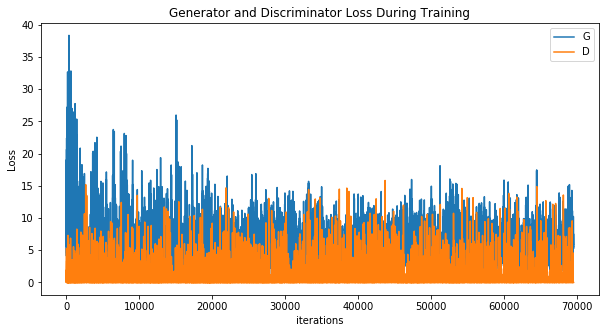

In [64]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [65]:
#%%capture
#fig = plt.figure(figsize=(8,8))
#plt.axis("off")
#ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
#ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

#HTML(ani.to_jshtml())

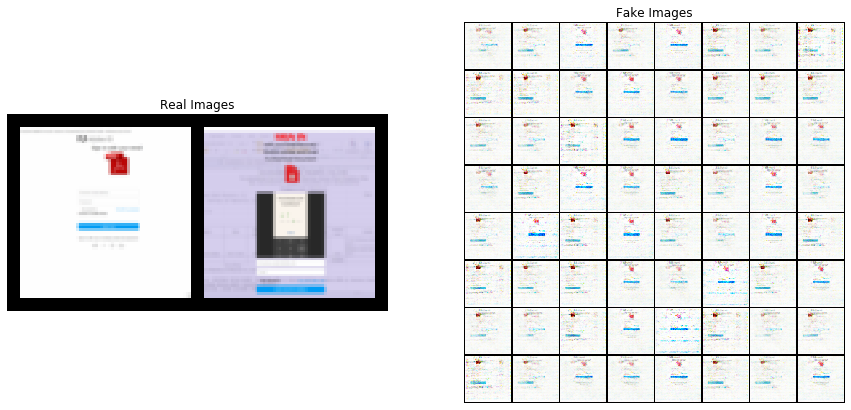

In [66]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [216]:
vutils.save_image(img_list[-1], "test.png")

In [214]:
with open('apple_gen', 'wb') as output:
    pickle.dump(netG, output, pickle.HIGHEST_PROTOCOL)

/home/vignesh_pagadala/anaconda3/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [215]:
with open('apple_disc', 'wb') as output:
    pickle.dump(netD, output, pickle.HIGHEST_PROTOCOL)

/home/vignesh_pagadala/anaconda3/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
